## STA 221 FINAL PROJECT
#### Team Members : Guneet Mummaneni, Kriti Kriti, Naresh Kumar Kaushal, Piyush Kulkarni

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Loading important Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pip
import glob
from tqdm import tqdm
import json
import pandas as pd
import re
import string
!pip install langdetect
from langdetect import detect
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from scipy.spatial import distance
! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
from gensim import  models
from gensim.test.utils import datapath
from gensim.matutils import cossim
from scipy.spatial import distance
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.svm import SVC

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 57.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=1f5b9445bb3652fa5337eb9fdfb043561cc365f16376a7586afa7c9731f00fc5
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


NotImplementedError: ignored

## Pre-processing data

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/covid_dataset.csv')
import pandas as pd
df = pd.read_json('/content/drive/MyDrive/STA221/covid_dataset.json', orient='records', lines=True)

In [ ]:
df.head()

In [ ]:
def clean_dataset(df_data):

    df_data['clean_body_text'] = df_data['body_text'].copy()

    ## remove content in square brackets
    df_data['clean_body_text'] = df_data['clean_body_text'].apply(lambda x : re.sub('\[.*?\]', '', x))
    print("removed all the contents between []")

    ## remove content in rond brackets
    df_data['clean_body_text'] = df_data['clean_body_text'].apply(lambda x : re.sub('\(.*?\)', '', x))
    print("removed all the cotents between ()")

    ## remove all whitespaces
    df_data['clean_body_text'] = df_data['clean_body_text'].apply(lambda x : re.sub('\s+', ' ', x))
    print("removed all whitespaces")

    ## remove all puntuations
    df_data['clean_body_text'] = df_data['clean_body_text'].apply(lambda x : re.sub(f"[{string.punctuation}]", "", x))
    print("removed all punctuations")

    ## remove all numbers
    df_data['clean_body_text'] = df_data['clean_body_text'].apply(lambda x : re.sub("\d+", "", x))
    print("removed all numbers")

    ## convert to lower case
    df_data['clean_body_text'] = df_data['clean_body_text'].apply(lambda x : x.lower())
    print("converted to lower case")

    df_data.drop_duplicates(['abstract', 'clean_body_text'], inplace=True)
    df_data.dropna(inplace=True)
    print("duplicates and rows with NA values removed")

    return df_data

In [ ]:
df_dataset = df.copy()
df_dataset_clean = clean_dataset(df_dataset)

In [ ]:
def filter_english_documents(df_data, show_non_english=False):

    non_english_docs_idxs = []

    for i in tqdm(range(df_data.shape[0])):

        if not detect(df_data.iloc[i]['clean_body_text']) == 'en':
            non_english_docs_idxs.append(i)

    if show_non_english:
        print("NON ENGLISH DOCUMENTS................. \n\n")
        for i in non_english_docs_idxs[:5]:
            print (df_data.iloc[i]['clean_body_text'][:250]+"......")
            print("="*100)


    df_data.drop(df_data.index[non_english_docs_idxs], inplace = True)
    return df_data

In [ ]:
def remove_small_papers(df_data, show_small_papers=False):

    small_paper_idxs = []
    for i in tqdm(range(df_data.shape[0])):
      if len(df_data.iloc[i]['clean_body_text']) < 500:
        small_paper_idxs.append(i)

    if show_small_papers:
      print("SMALL PAPERS..................\n\n")
      count = 0

      for i in small_paper_idxs:

        count += 1
        print (df_data.iloc[i]['clean_body_text'][:250]+"......")
        print("="*100)

        if count == 5:
            break

    df_data.drop(df_data.index[small_paper_idxs], inplace=True)
    return df_data

In [ ]:
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    #remove stop words
    tokens = list(filter(lambda x: x not in stop_words, tokens))
    #lemmatize the words so that other forms of same word becomes a single word
    tokens = list(map(lambda x: nltk.WordNetLemmatizer().lemmatize(x), tokens))
    # remove tokens with length < 2
    tokens = list(filter(lambda x: len(x) > 2, tokens))
    return ' '.join(list(tokens))

In [ ]:
df_dataset_without_small_papers = remove_small_papers(df_dataset_clean, True)
df_dataset_eng = filter_english_documents(df_dataset_without_small_papers, True)
df_data_final = df_dataset_eng.copy()
df_data_final.head()

In [ ]:
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure',
    'rights', 'reserved', 'permission', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'elsevier', 'pmc', 'czi',
    '-pron-'
]
stop_words = set(stopwords.words('english')).union(STOP_WORDS).union(set(customize_stop_words))

In [ ]:
df_data_final["tokenized_text"] = df_data_final["clean_body_text"].apply(tokenize_text)
df_data_final["tokens"] = df_data_final["tokenized_text"].apply(lambda x: x.split())

In [ ]:
# Save DataFrame as JSON
df_data_final.to_json('clean_data.json', orient='records', lines=True)

In [ ]:
df_data_final = pd.read_json('/content/drive/MyDrive/STA221/clean_data.json', orient='records', lines=True)

In [ ]:
df_data_final.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,paper_id,title,abstract,body_text,authors,clean_body_text,tokenized_text,tokens
0,8f97e16f3842e4bbd2d5d1c0c95ac1e31993ec68,An update on excess mortality in the second ye...,"In this short note, we apply the method of De ...","Expected deaths by year, represented by blue s...","Asta Wirtsch ,Sozialstat Arch ,Giacomo De Nico...",expected deaths by year represented by blue sq...,expected death year represented blue square pl...,"[expected, death, year, represented, blue, squ..."
1,8187ea360c53a56ca2c579d758a5d6aa67716836,,,Research Letter to the Editor:\nWe are writing...,,research letter to the editor we are writing t...,research letter editor writing attention profo...,"[research, letter, editor, writing, attention,..."
2,a0d063dca746b135afe0451ce0b3bb1e06cf15ae,Ethnic and regional variations in hospital mor...,Background Brazil ranks second worldwide in to...,The COVID-19 pandemic has created an unprecede...,"Núcleo De Astrofísica E Cosmologia ,P Baqui ,V...",the covid pandemic has created an unprecedente...,covid pandemic created unprecedented worldwide...,"[covid, pandemic, created, unprecedented, worl..."
3,e0777fb5df224525ee1b06008582b084c1b6b13b,"Association between central blood pressure, ar...","The burden of hypertension in South Africa, as...",Raised blood pressure (BP) and hypertension ar...,"Feziwe Mpondo ,Ashleigh Craig ,Andrea Kolkenbe...",raised blood pressure and hypertension are wel...,raised blood pressure hypertension wellknown m...,"[raised, blood, pressure, hypertension, wellkn..."
4,ee5af71875f2e77135974c75980ce22fff03e4f8,What Is Critical About the Crisis of Expertise...,,"Particularly in these pandemic times, appeals ...",Riccardo Chesta,particularly in these pandemic times appeals t...,particularly pandemic time appeal state crisis...,"[particularly, pandemic, time, appeal, state, ..."


In [ ]:
# Convert GloVe format to Word2Vec format
glove_file = '/content/drive/MyDrive/STA221/glove.6B.100d.txt'
word2vec_file = '/content/drive/MyDrive/STA221/glove.6B.100d.word2vec'
glove2word2vec(glove_file, word2vec_file)

# Load GloVe word embeddings
# This takes 2 minutes to run
word_vectors = KeyedVectors.load_word2vec_format(word2vec_file)

In [ ]:
def tokens_to_vectors(tokens):
    vectors = []
    for token in tokens:
        if token in word_vectors.key_to_index:
            vectors.append(word_vectors.get_vector(token))
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word_vectors.vector_size)

## Query Pre-processing

In [ ]:
def clean_query(query):

    query = re.sub('\[.*?\]', '', query)
    query = re.sub('\(.*?\)', '', query)
    query = re.sub('\s+', ' ', query)
    query = re.sub(f"[{string.punctuation}]", "", query)
    query = query.lower()

    return query

In [ ]:
Queries = {
'query_prompt' : ['What is known about transmission, incubation, and environmental stability?',
'What do we know about COVID-19 risk factors?',
'What do we know about virus genetics, origin, and evolution?',
'What do we know about non-pharmaceutical interventions?',
'What do we know about vaccines and therapeutics?',
'What has been published about ethical and social science considerations?',
'What do we know about diagnostics and surveillance?',
'What has been published about medical care?',
'What has been published about information sharing and inter-sectoral collaboration?'],

'query_description' : ["Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery."+
"Prevalence of asymptomatic shedding and transmission (e.g., particularly children)."+
"Seasonality of transmission."+
"Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding)."+
"Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood)."+
"Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic)."+
"Natural history of the virus and shedding of it from an infected person"+
"Implementation of diagnostics and products to improve clinical processes"+
"Disease models, including animal models for infection, disease and transmission"+
"Tools and studies to monitor phenotypic change and potential adaptation of the virus"+
"Immune response and immunity"+
"Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings"+
 "Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings"+
"Role of the environment in transmission",

'Data on potential risks factors'+
'Smoking, pre-existing pulmonary disease'+
'Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities'+
'Neonates and pregnant women'+
'Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.'+
'Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors'+
'Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups'+
'Susceptibility of populations'+
'Public health mitigation measures that could be effective for control',

'Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.'+
'Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.'+
'Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.'+
'Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.'+
'Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.'+
'Experimental infections to test host range for this pathogen.'+
'Animal host(s) and any evidence of continued spill-over to humans'+
'Socioeconomic and behavioral risk factors for this spill-over'+
'Sustainable risk reduction strategies',

"Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases."+
"Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments."+
"Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches."+
"Methods to control the spread in communities, barriers to compliance and how these vary among different populations.."+
"Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status."+
"Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs."+
"Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high)."+
"Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay.",

"Effectiveness of drugs being developed and tried to treat COVID-19 patients. Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication."+
"Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients."+
"Exploration of use of best animal models and their predictive value for a human vaccine."+
"Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents."+
"Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need."+
"Efforts targeted at a universal coronavirus vaccine."+
"Efforts to develop animal models and standardize challenge studies"+
"Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers"+
"Approaches to evaluate risk for enhanced disease after vaccination"+
"Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]",

"Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019"+
"Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight"+
"Efforts to support sustained education, access, and capacity building in the area of ethics"+
"Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences."+
"Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)"+
"Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed."+
"Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media.",

"How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures. Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible. Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples) and early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs)."+
"Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms."+
"Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues."+
"National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public)."+
"Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy."+
"Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity. These experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded)."+
"Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices."+
"Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes."+
"Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling."+
"Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions."+
"Policies and protocols for screening and testing."+
"Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents."+
"Technology roadmap for diagnostics."+
"Barriers to developing and scaling up new diagnostic tests (e.g., market forces), how future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment."+
"New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases."+
"Coupling genomics and diagnostic testing on a large scale."+
"Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant."+
"Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional."+
"One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors.",


"Resources to support skilled nursing facilities and long term care facilities."+
"Mobilization of surge medical staff to address shortages in overwhelmed communities"+
"Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure - particularly for viral etiologies"+
"Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients"+
"Outcomes data for COVID-19 after mechanical ventilation adjusted for age."+
"Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest."+
"Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level."+
"Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks."+
"Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries."+
"Guidance on the simple things people can do at home to take care of sick people and manage disease."+
"Oral medications that might potentially work."+
"Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually."+
"Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes."+
"Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials"+
"Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials"+
"Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)",

"Methods for coordinating data-gathering with standardized nomenclature."+
"Sharing response information among planners, providers, and others."+
"Understanding and mitigating barriers to information-sharing."+
"How to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic)."+
"Integration of federal/state/local public health surveillance systems."+
"Value of investments in baseline public health response infrastructure preparedness"+
"Modes of communicating with target high-risk populations (elderly, health care workers)."+
"Risk communication and guidelines that are easy to understand and follow (include targeting at risk populations' families too)."+
"Communication that indicates potential risk of disease to all population groups."+
"Misunderstanding around containment and mitigation."+
"Action plan to mitigate gaps and problems of inequity in the Nation's public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment."+
"Measures to reach marginalized and disadvantaged populations."+
"Data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities."+
"Mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment."+
"Understanding coverage policies (barriers and opportunities) related to testing, treatment, and care"]

}

In [ ]:
query_db = pd.DataFrame(Queries)
query_db['clean_queries'] = query_db['query_description'].copy()
query_db['clean_queries'] = query_db['clean_queries'].apply(clean_query)
query_db['tokenized_query'] = query_db['clean_queries'].apply(tokenize_text)
query_db['query_tokens'] = query_db['tokenized_query'].apply(lambda x: x.split())
# query_db['vectors'] = query_db['tokenized_query'].apply(lambda x: tokens_to_vectors(x.split()))

In [ ]:
query_db.head()

,query_prompt,query_description,clean_queries,tokenized_query,query_tokens
0,"What is known about transmission, incubation, ...",Range of incubation periods for the disease in...,range of incubation periods for the disease in...,range incubation period disease human long ind...,"[range, incubation, period, disease, human, lo..."
1,What do we know about COVID-19 risk factors?,"Data on potential risks factorsSmoking, pre-ex...",data on potential risks factorssmoking preexis...,data potential risk factorssmoking preexisting...,"[data, potential, risk, factorssmoking, preexi..."
2,"What do we know about virus genetics, origin, ...",Real-time tracking of whole genomes and a mech...,realtime tracking of whole genomes and a mecha...,realtime tracking genome mechanism coordinatin...,"[realtime, tracking, genome, mechanism, coordi..."
3,What do we know about non-pharmaceutical inter...,Guidance on ways to scale up NPIs in a more co...,guidance on ways to scale up npis in a more co...,guidance way scale npis coordinated way collab...,"[guidance, way, scale, npis, coordinated, way,..."
4,What do we know about vaccines and therapeutics?,Effectiveness of drugs being developed and tri...,effectiveness of drugs being developed and tri...,effectiveness drug developed tried treat covid...,"[effectiveness, drug, developed, tried, treat,..."


In [ ]:
query_db.to_json('query_db.json', orient='records', lines=True)

In [ ]:
query_db = pd.read_json('/content/drive/MyDrive/STA221/query_db.json', orient='records', lines=True)

# MODELS

## K-Nearest Neighbours (KNN)
#### By Guneet Mummaneni

In [ ]:
# Vectorize the text data
vectorizer = TfidfVectorizer()
X_data = vectorizer.fit_transform(df_data_final['tokenized_text'])

In [ ]:
# Train k-NN model on the data
knn  = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X_data)

In [ ]:
# Initialize an empty list to store average cosine scores
avg_cosine_scores = []


In [ ]:
# Process each query
for i, query in enumerate(query_db['tokenized_query']):
    print(f"Processing Query {i+1}...\n")

    # Transform the query data
    X_query = vectorizer.transform(pd.Series([query]))

    # Find the 5 documents closest to the query
    distances, indices = knn.kneighbors(X_query)

    # Compute average cosine score for this query
    avg_cosine_scores.append(np.mean(1 - distances)) # As we're using cosine metric in NearestNeighbors, distances are cosine distances. So, to convert it to similarity we subtract it from 1

    # Print the top 5 closest documents for each query
    for index, distance in zip(indices[0], distances[0]):
        print("TITLE: " + df_data_final["title"].iloc[index])
        print("BODY: " + df_data_final["body_text"].iloc[index][:500])
        print("Similarity Score: ", 1 - distance) # Convert cosine distance to similarity
        print("\n")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Processing Query 1...

TITLE: The sudden appearance of SARS-CoV-2 1
BODY: Numerous viral infections have risen in the last decades, causing severe diseases associated with lethality. Diseases have varied in epidemiology and morbidity although people with risk factors such as age, cardiovascular diseases, diabetes, and other chronic diseases have most commonly suffered more serious consequences. The world population is aging and so is the prevalence of noncommunicable diseases. Thus, the potential group of people, who are the most at risk of suffering major consequence
Similarity Score:  0.2461321822326864


TITLE: Understanding COVID-19 transmission, health impacts and mitigation: timely social distancing is the key Change point
BODY: COVID-19 is caused by novel strain of virus SARS-CoV-2 emerged from China and now declared as pandemic due to its presence across the continents in more than 213 countries. Based on genetic analysis SARS-CoV-2 is grouped in a family Coronaviridae, genus B

In [ ]:
# Print the average cosine scores
for i, score in enumerate(avg_cosine_scores):
    print(f'Average cosine score for query {i+1}: {score}')


Average cosine score for query 1: 0.22208353007328094
Average cosine score for query 2: 0.22151599699440486
Average cosine score for query 3: 0.1986976391663244
Average cosine score for query 4: 0.24673291604316921
Average cosine score for query 5: 0.24520891859070862
Average cosine score for query 6: 0.20305814549592355
Average cosine score for query 7: 0.216223409306056
Average cosine score for query 8: 0.23766971240486492
Average cosine score for query 9: 0.2252013584883378


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## K-Means & SVM
#### By Piyush Santosh Kulkarni

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

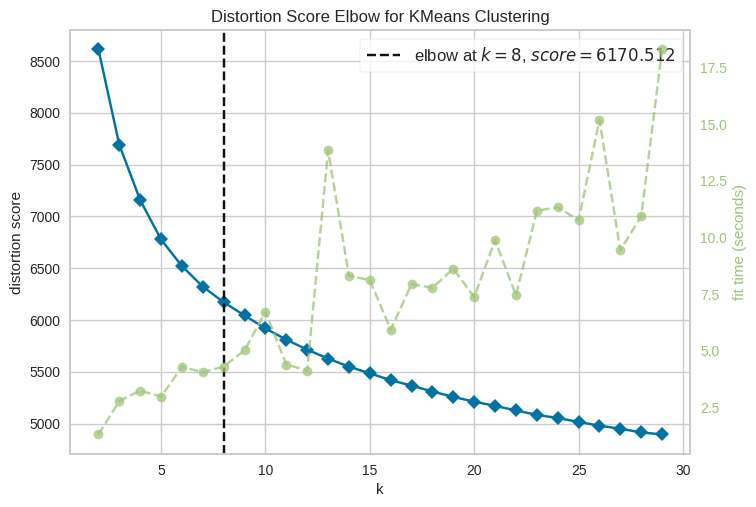

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#install yellowbrick to vizualize the Elbow curve
!pip install yellowbrick

from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


# Instantiate the clustering model and visualizer
kmeans = KMeans(random_state=42)
X = np.stack(df_data_final['vectors'].values)
visualizer = KElbowVisualizer(kmeans, k=(2,30))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

====We can see that using k=8 gives us the best results hence for kmeans clustering we will consider k=8====

In [ ]:
df_data_final['vectors'] = df_data_final['tokenized_text'].apply(lambda x: tokens_to_vectors(x.split()))

# # Apply K-means clustering
k = 8  # WE use k=8 after our elbow analysis on the data
kmeans = KMeans(n_clusters=k, random_state=42)
df_data_final['cluster_label'] = kmeans.fit_predict(np.stack(df_data_final['vectors'].values))

In [ ]:
df_data_final.to_json('/content/drive/MyDrive/STA221/data_with_Kmean_labels1.json', orient='records', lines=True)

In [ ]:
df_data_final = pd.read_json('/content/drive/MyDrive/STA221/data_with_Kmean_labels.json', orient='records', lines=True)

In [ ]:
df_data_final.head()

,paper_id,title,abstract,body_text,authors,clean_body_text,tokenized_text,tokens,vectors,cluster_label
0,8f97e16f3842e4bbd2d5d1c0c95ac1e31993ec68,An update on excess mortality in the second ye...,"In this short note, we apply the method of De ...","Expected deaths by year, represented by blue s...","Asta Wirtsch ,Sozialstat Arch ,Giacomo De Nico...",expected deaths by year represented by blue sq...,expected death year represented blue square pl...,"[expected, death, year, represented, blue, squ...","[-0.07715285, 0.2339434, 0.17645541, 0.1018100...",2
1,8187ea360c53a56ca2c579d758a5d6aa67716836,,,Research Letter to the Editor:\nWe are writing...,,research letter to the editor we are writing t...,research letter editor writing attention profo...,"[research, letter, editor, writing, attention,...","[-0.04930564, 0.17999654, 0.023094004, 0.22998...",0
2,a0d063dca746b135afe0451ce0b3bb1e06cf15ae,Ethnic and regional variations in hospital mor...,Background Brazil ranks second worldwide in to...,The COVID-19 pandemic has created an unprecede...,"Núcleo De Astrofísica E Cosmologia ,P Baqui ,V...",the covid pandemic has created an unprecedente...,covid pandemic created unprecedented worldwide...,"[covid, pandemic, created, unprecedented, worl...","[-0.053038947, 0.21664743, 0.26520357, 0.14516...",2
3,e0777fb5df224525ee1b06008582b084c1b6b13b,"Association between central blood pressure, ar...","The burden of hypertension in South Africa, as...",Raised blood pressure (BP) and hypertension ar...,"Feziwe Mpondo ,Ashleigh Craig ,Andrea Kolkenbe...",raised blood pressure and hypertension are wel...,raised blood pressure hypertension wellknown m...,"[raised, blood, pressure, hypertension, wellkn...","[-0.059758972, 0.20353447, 0.13864446, 0.18294...",5
4,ee5af71875f2e77135974c75980ce22fff03e4f8,What Is Critical About the Crisis of Expertise...,,"Particularly in these pandemic times, appeals ...",Riccardo Chesta,particularly in these pandemic times appeals t...,particularly pandemic time appeal state crisis...,"[particularly, pandemic, time, appeal, state, ...","[-0.05847094, 0.15457007, 0.175447, 0.17115949...",7


Creating and Training SVM

In [ ]:
X_train = np.stack(df_data_final['vectors'].values)
y_train = df_data_final['cluster_label'].values

svm = SVC()
svm.fit(X_train, y_train)

Finding top 5 Similar papers

In [ ]:
# Process each query

cosine_averages=[]

for i, query in enumerate(query_db['tokenized_query']):
    print('========================================================================')
    print(f"Processing Query {i+1}...\n")
    print('==========================================================================')

    # Transform the query data

    vector_query = tokens_to_vectors(query.split()).reshape(1, -1)

    # Predict cluster label for query
    y_test = svm.predict(vector_query)
    print("Predicted cluster label:", y_test)


    # Create the updated dataframe using the prvious predicted cluster
    df_updated = df_data_final[df_data_final['cluster_label'] == y_test[0]].copy()

    # Reset the index of the new DataFrame
    df_updated.reset_index(drop=True, inplace=True)
    from sklearn.metrics.pairwise import cosine_distances

    # Compute cosine distances between vector_query and all vectors in df_data_final
    distances = cosine_distances(vector_query, np.stack(df_updated['vectors'].values))

    # Find the indices of the 5 most similar rows
    # top_indices = np.argsort(distances)[0][:5]
    top_indices = np.argsort(distances)[0][::-1][:5]
    # Retrieve the corresponding rows from df_data_final
    most_similar_rows = df_updated.iloc[top_indices]

    # Print the most similar rows

    print('5 Most Similar Papers')
    # most_similar_rows = most_similar_rows[['title','body_text']]

    print(most_similar_rows[['title','body_text']])

    print('Average Cosine Similarity of query with 5 papers')
    average = np.mean(1-distances[0][top_indices])
    cosine_averages.append(average)
    print(average)

In [ ]:
cosine_averages

##RANDOM FOREST

####KRITI KRITI

Creating and Traning the Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# Prepare the training data
X_train = np.stack(df_data_final['vectors'].values)
y_train = df_data_final['cluster_label'].values

# Train the Random Forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

RUNNING FOR ALL 10 QUERIES

In [ ]:
cosine_averages_random_forest=[]

for i, query in enumerate(query_db['tokenized_query']):
    print('========================================================================')
    print(f"Processing Query {i+1}...\n")
    print('==========================================================================')

    # Transform the query data

    vector_query = tokens_to_vectors(query.split()).reshape(1, -1)

    # Predict cluster label for query
    y_test = rf.predict(vector_query)
    print("Predicted cluster label:", y_test)


    # Create the updated dataframe using the prvious predicted cluster
    df_updated = df_data_final[df_data_final['cluster_label'] == y_test[0]].copy()

    # Reset the index of the new DataFrame
    df_updated.reset_index(drop=True, inplace=True)
    from sklearn.metrics.pairwise import cosine_distances

    # Compute cosine distances between vector_query and all vectors in df_data_final
    distances = cosine_distances(vector_query, np.stack(df_updated['vectors'].values))

    # Find the indices of the 5 most similar rows
    # top_indices = np.argsort(distances)[0][:5]
    top_indices = np.argsort(distances)[0][::-1][:5]
    # Retrieve the corresponding rows from df_data_final
    most_similar_rows = df_updated.iloc[top_indices]

    # Print the most similar rows

    print('5 Most Similar Papers')
    # most_similar_rows = most_similar_rows[['title','body_text']]

    print(most_similar_rows[['title','body_text']])

    print('Average Cosine Similarity of query with 5 papers')
    average = np.mean(1-distances[0][top_indices])
    cosine_averages_random_forest.append(average)
    print(average)

##CNN

Creating and Training the CNN Model

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Prepare the training data
num_classes=8
X_train = np.stack(df_data_final['vectors'].values)
y_train = df_data_final['cluster_label'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape the input data for 1D convolutional layer
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)

# Define the model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=((X_train.shape[1], 1))))
model.add(GlobalMaxPooling1D())
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
368/368 [==============================] - 12s 6ms/step - loss: 2.0180 - accuracy: 0.1931 - val_loss: 1.9825 - val_accuracy: 0.2004
Epoch 2/10
368/368 [==============================] - 1s 4ms/step - loss: 1.9398 - accuracy: 0.2524 - val_loss: 1.8860 - val_accuracy: 0.2579
Epoch 3/10
368/368 [==============================] - 1s 4ms/step - loss: 1.8108 - accuracy: 0.3167 - val_loss: 1.7282 - val_accuracy: 0.3869
Epoch 4/10
368/368 [==============================] - 1s 4ms/step - loss: 1.6438 - accuracy: 0.4414 - val_loss: 1.5639 - val_accuracy: 0.4951
Epoch 5/10
368/368 [==============================] - 2s 5ms/step - loss: 1.4945 - accuracy: 0.5163 - val_loss: 1.4294 - val_accuracy: 0.5083
Epoch 6/10
368/368 [==============================] - 2s 7ms/step - loss: 1.3758 - accuracy: 0.5692 - val_loss: 1.3243 - val_accuracy: 0.6281
Epoch 7/10
368/368 [==============================] - 2s 4ms/step - loss: 1.2805 - accuracy: 0.6055 - val_loss: 1.2418 - val_accuracy: 0.5982
Epoch

RUNNING FOR ALL 10 QUERIES

In [ ]:
cosine_averages_cnn=[]

for i, query in enumerate(query_db['tokenized_query']):
    print('========================================================================')
    print(f"Processing Query {i+1}...\n")
    print('==========================================================================')

    # Transform the query data

    vector_query = tokens_to_vectors(query.split()).reshape(1, -1)

    # Predict cluster label for query
    # y_test = rf.predict(vector_query)
    model.predict(vector_query)
    print("Predicted cluster label:", y_test)


    # Create the updated dataframe using the prvious predicted cluster
    df_updated = df_data_final[df_data_final['cluster_label'] == y_test[0]].copy()

    # Reset the index of the new DataFrame
    df_updated.reset_index(drop=True, inplace=True)
    from sklearn.metrics.pairwise import cosine_distances

    # Compute cosine distances between vector_query and all vectors in df_data_final
    distances = cosine_distances(vector_query, np.stack(df_updated['vectors'].values))

    # Find the indices of the 5 most similar rows
    # top_indices = np.argsort(distances)[0][:5]
    top_indices = np.argsort(distances)[0][::-1][:5]
    # Retrieve the corresponding rows from df_data_final
    most_similar_rows = df_updated.iloc[top_indices]

    # Print the most similar rows

    print('5 Most Similar Papers')
    # most_similar_rows = most_similar_rows[['title','body_text']]

    print(most_similar_rows[['title','body_text']])

    print('Average Cosine Similarity of query with 5 papers')
    average = np.mean(1-distances[0][top_indices])
    cosine_averages_cnn.append(average)
    print(average)

Processing Query 1...

1/1 [==============================] - 0s 32ms/step
Predicted cluster label: [0]
5 Most Similar Papers
                                                  title  \
2353  Correction to: At the US Epicenter of the COVI...   
1408  Music Therapy for the Treatment of Patients Wi...   
1289                                                      
1242  To cite: Saad NJ. The Al Hol camp in Northeast...   
1372  Changes in the pattern of Heart Failure and Di...   

                                              body_text  
2353  The published article listed co-authors in a c...  
1408  Nurses, doctors, and counselors/psychologists ...  
1289  In 1969 man landed on the moon, how can we als...  
1242  With the world in the grip of COVID-19 pandemi...  
1372  . The data were collected from Jan 11 th to Ju...  
Average Cosine Similarity of query with 5 papers
0.8163182
Processing Query 2...

1/1 [==============================] - 0s 39ms/step
Predicted cluster label: [0]
5 Most S

Comparing the 3 models

In [ ]:
cosine_averages ## For SVM

[0.8477316,
 0.8312985,
 0.8146551,
 0.83354366,
 0.803642,
 0.8097035,
 0.81958944,
 0.8355192,
 0.8041363]

In [ ]:
cosine_averages_random_forest

[0.8477316,
 0.8312985,
 0.65994734,
 0.8311782,
 0.803642,
 0.8097035,
 0.8075408,
 0.8355192,
 0.8041363]

In [ ]:
cosine_averages_cnn

[0.8163182,
 0.79062927,
 0.780982,
 0.83354366,
 0.7746641,
 0.8126706,
 0.8075408,
 0.8355192,
 0.8041363]

## Latent Dirichlet Allocation (LDA)
#### By Naresh Kumar Kaushal

In [ ]:
dictionary = Dictionary(df_data_final["tokens"])
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [ ]:
query_bows = [dictionary.doc2bow(x) for x in query_db['query_tokens'].values]

In [ ]:
corpus = df_data_final["tokens"].apply(lambda x: dictionary.doc2bow(x))
corpus

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        [(0, 2), (1, 1), (2, 1), (3, 6), (4, 1), (5, 1...
1        [(0, 1), (31, 2), (34, 1), (77, 1), (118, 1), ...
2        [(0, 11), (3, 12), (12, 17), (15, 2), (18, 2),...
3        [(3, 9), (5, 1), (8, 1), (12, 3), (15, 1), (19...
4        [(0, 2), (1, 1), (2, 1), (6, 1), (7, 2), (9, 4...
                               ...                        
14687    [(3, 2), (18, 2), (19, 1), (27, 2), (35, 1), (...
14688    [(3, 47), (4, 1), (5, 2), (8, 2), (15, 4), (16...
14689    [(0, 1), (1, 1), (2, 2), (3, 7), (7, 1), (18, ...
14690    [(0, 2), (2, 1), (3, 1), (7, 2), (9, 6), (18, ...
14691    [(0, 7), (1, 1), (3, 4), (7, 1), (8, 1), (12, ...
Name: tokens, Length: 14692, dtype: object

In [ ]:
lda = LdaMulticore(corpus, id2word=dictionary, num_topics=10, workers = 4, chunksize=200, passes=10, random_state = 100)

In [ ]:
lda.save("lda_model")

In [ ]:
lda = models.LdaModel.load("/content/drive/MyDrive/STA221/lda_model/model3/lda_model")

In [ ]:
lda.print_topics()[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.017*"participant" + 0.009*"social" + 0.009*"child" + 0.008*"mental" + 0.008*"student" + 0.007*"survey" + 0.007*"anxiety" + 0.006*"score" + 0.006*"people" + 0.006*"age"'),
 (1,
  '0.008*"hospital" + 0.007*"trial" + 0.007*"sarscov" + 0.006*"symptom" + 0.006*"testing" + 0.006*"participant" + 0.005*"cancer" + 0.005*"review" + 0.005*"month" + 0.004*"woman"'),
 (2,
  '0.006*"service" + 0.006*"social" + 0.005*"community" + 0.005*"public" + 0.004*"people" + 0.004*"experience" + 0.004*"practice" + 0.004*"student" + 0.003*"technology" + 0.003*"medical"'),
 (3,
  '0.017*"sarscov" + 0.014*"protein" + 0.007*"cell" + 0.007*"viral" + 0.007*"antibody" + 0.006*"rna" + 0.006*"assay" + 0.006*"binding" + 0.006*"sequence" + 0.005*"structure"'),
 (4,
  '0.008*"learning" + 0.008*"image" + 0.007*"network" + 0.007*"feature" + 0.006*"performance" + 0.006*"set" + 0.005*"algorithm" + 0.005*"proposed" + 0.004*"training" + 0.004*"dataset"'),
 (5,
  '0.036*"cell" + 0.009*"immune" + 0.009*"expression" + 0.0

In [ ]:
pyLDAvis.enable_notebook()
vis_0 = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
vis_0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.157577 -0.004116       1        1  17.036241
0     -0.116544 -0.112766       2        1  11.186576
3      0.188284  0.155175       3        1  11.115007
1      0.016339 -0.159314       4        1  10.777018
4     -0.062085  0.132152       5        1  10.190506
5      0.256875  0.014782       6        1  10.105147
8     -0.054173  0.036917       7        1   9.668334
6      0.108171 -0.183951       8        1   8.996886
7     -0.140379  0.092505       9        1   6.258070
9     -0.038911  0.028615      10        1   4.666216, topic_info=             Term          Freq         Total Category  logprob  loglift
1735         cell  87729.000000  87729.000000  Default  30.0000  30.0000
2369      vaccine  46168.000000  46168.000000  Default  29.0000  29.0000
1044  participant  57249.000000  57249.000000  Default  28.0000  28.0000
2201      protein  46225.000000  46225.000000  Default  27.0000  27.0000
738       sarscov  83449.000000  83449.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1353        human   3026.421928  33875.852269  Topic10  -5.7133   0.6495
458       country   2835.018416  41944.458559  Topic10  -5.7786   0.3705
3011  environment   2395.693772  14816.558789  Topic10  -5.9470   1.2427
195     effective   2373.707608  18928.907132  Topic10  -5.9562   0.9886
207      exposure   2339.820852  15834.441841  Topic10  -5.9706   1.1527

[922 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
21943      7  0.995275          abm
844        2  0.002275  abnormality
844        4  0.048145  abnormality
844        5  0.019713  abnormality
844        6  0.062551  abnormality
...      ...       ...          ...
17361      9  0.994427          wto
19083      4  0.997762        xpert
16975      9  0.996227      yangtze
6345       1  0.996304        youre
20168      7  0.998593          μgm

[3607 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2, 5, 6, 9, 7, 8, 10])

In [ ]:
'''
Check which topic our query belongs to using the LDA BOW model.
'''
for index, score in sorted(lda[query_bows[4]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda.print_topic(index, 10)))


Score: 0.3560207784175873	 
Topic: 0.036*"cell" + 0.009*"immune" + 0.009*"expression" + 0.009*"sarscov" + 0.008*"gene" + 0.008*"protein" + 0.007*"mouse" + 0.007*"viral" + 0.006*"human" + 0.006*"lung"

Score: 0.24341458082199097	 
Topic: 0.006*"service" + 0.006*"social" + 0.005*"community" + 0.005*"public" + 0.004*"people" + 0.004*"experience" + 0.004*"practice" + 0.004*"student" + 0.003*"technology" + 0.003*"medical"

Score: 0.23521192371845245	 
Topic: 0.047*"vaccine" + 0.023*"vaccination" + 0.016*"food" + 0.013*"mask" + 0.006*"water" + 0.006*"vaccinated" + 0.006*"product" + 0.005*"animal" + 0.004*"face" + 0.004*"protection"

Score: 0.15687468647956848	 
Topic: 0.008*"hospital" + 0.007*"trial" + 0.007*"sarscov" + 0.006*"symptom" + 0.006*"testing" + 0.006*"participant" + 0.005*"cancer" + 0.005*"review" + 0.005*"month" + 0.004*"woman"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_prob_vectors(lda_vec1, lda_vec2):

  vec1 = [0 for i in range(10)]
  vec2 = [0 for i in range(10)]

  for (idx, prob) in lda_vec1:
    vec1[idx] = prob

  for (idx, prob) in lda_vec2:
    vec2[idx] = prob

  return vec1, vec2

In [ ]:
def get_similar_doc(q_bow, doc_bow, model_lda):

    lda_vec1 = model_lda[q_bow]
    jensen_sim = []
    i = 0
    for doc in doc_bow:
        lda_vec2 = model_lda[doc]
        q_vec, d_vec = get_prob_vectors(lda_vec1, lda_vec2)
        similarity = distance.jensenshannon(q_vec, d_vec)
        jensen_sim.append(similarity)
        i= i+1

    ## Sorting based on cosine values and getting top 5 documents
    res = sorted(range(len(jensen_sim)), key = lambda i: jensen_sim[i])[:5]

    return res

In [ ]:
most_similar_docs = []
for query_bow in query_bows:
  sim_docs = get_similar_doc(query_bow, corpus, lda)
  most_similar_docs.append(sim_docs)

In [ ]:
for idx in reversed(most_similar_docs[4]):
    print("TITLE: " + df_data_final["title"].iloc[idx]+'\n')
    print("AUTHORS: " + df_data_final["authors"].iloc[idx]+'\n')
    print("BODY: " + df_data_final["body_text"].iloc[idx][:500]+'\n')

TITLE: CommenT

AUTHORS: 

BODY: The past decade, and particularly the past few years, has seen a rapid acceleration in novel vaccine develop ment, owing to public health emergencies (such as COVID-19 and Ebola), public health urgencies (cholera, meningococcal disease and others) and public health necessities (pneumococcal disease, influenza, hepatitis B and others), as well as improvements to existing vaccines. These developments have been made possible and informed by advances in basic biology and vaccine science, including n

TITLE: Light and health: a century after the therapeutic use of UV light and vitamin D, hormones advanced medical care

AUTHORS: Josef Köhrle ,Martina Rauner ,Susan Lanham-New ,Susan Lanham-New

BODY: Contemporary medicine focuses its therapeutic approaches on the personalized targeting of key molecular elements with respect to mechanism-based pathways, or molecules involved in pathophysiologically relevant processes that are causally related (or indeed associa

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from tqdm.notebook import tqdm
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

#### Fonction to estimate the optimal number of topics (i.e., the one maximizing C_Umass) ####

def optimal_topic_number(start, end):

    Lda = gensim.models.ldamodel.LdaModel
    coherenceList_cv = []
    coherenceList_umass = []

    num_topics_list = np.arange(start,end)

    for num_topics in tqdm(num_topics_list):
        lda= Lda(corpus, num_topics=num_topics,id2word = dictionary,
                 passes=10,chunksize=200,random_state=43)
        cm = CoherenceModel(model=lda, corpus=corpus,
                            dictionary=dictionary, coherence='u_mass')
        coherenceList_umass.append(cm.get_coherence())


    plotData = pd.DataFrame({'Number of topics':num_topics_list,
                             'CoherenceScore':coherenceList_umass})
    f,ax = plt.subplots(figsize=(10,6))
    sns.set_style("darkgrid")
    sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
    plt.title('Topic coherence \n', fontsize = 24, fontweight = "bold")
    plt.savefig('Topic_Coherence.png')
    plt.show()
    index = coherenceList_umass.index(max(coherenceList_umass))
    return index

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/15 [00:00<?, ?it/s]

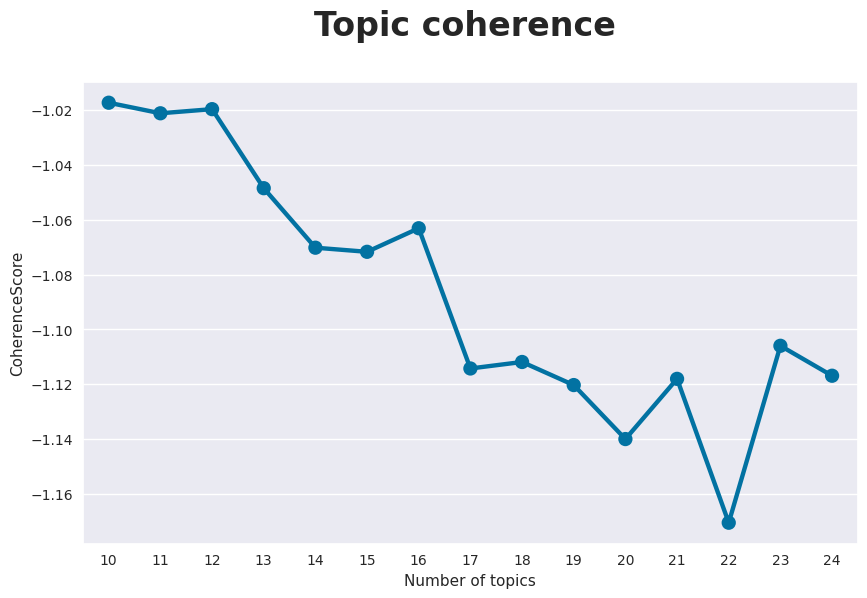

In [ ]:
import time
t = time.time()

start = 10
end = 25

num_optimal_topics = start + optimal_topic_number(start, end)

In [ ]:
print("Optimal Number of Topics", num_optimal_topics)

print('Time to process data: {} mins'.format(round((time.time() - t) / 60, 2)))

Optimal Number of Topics 10
Time to process data: 143.69 mins


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Evaluation

In [ ]:
def get_cosine_sim(doc_vec, query_vec):
    # print(doc_vec.shape, query_vec.shape)
    norm_doc_vec = np.linalg.norm(doc_vec)
    norm_query_vec = np.linalg.norm(query_vec)
    # query_vec = query_vec.reshape(query_vec.shape[0], 1)
    dot_prod = np.dot(doc_vec, query_vec)
    prod_norm = norm_doc_vec * norm_query_vec
    # prod_norm = prod_norm.reshape(prod_norm.shape[0], 1)
    cosine_sim = dot_prod / prod_norm
    return cosine_sim

In [ ]:
def get_average_cosine_scores(docs):

  avg_sims = []
  # print(query_db['vectors'].values.shape[0])
  for i in range(query_db['vectors'].values.shape[0]):
    query_vec = np.array(query_db['vectors'].iloc[i])
    sim = 0
    for j in docs[i]:
      # print(i)
      doc_vec = df_data_final["vectors"].iloc[j]
      sim = sim + get_cosine_sim(doc_vec, query_vec)
    avg_sim = sim/len(docs)
    avg_sims.append(avg_sim)

  return avg_sims


Evaluation for k-NN

In [ ]:
# Print the average cosine scores
for i, score in enumerate(avg_cosine_scores):
    print(f'Average cosine score for query {i+1}: {score}')


Average cosine score for query 1: 0.22208353007328094
Average cosine score for query 2: 0.22151599699440486
Average cosine score for query 3: 0.1986976391663244
Average cosine score for query 4: 0.24673291604316921
Average cosine score for query 5: 0.24520891859070862
Average cosine score for query 6: 0.20305814549592355
Average cosine score for query 7: 0.216223409306056
Average cosine score for query 8: 0.23766971240486492
Average cosine score for query 9: 0.2252013584883378


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Evaluation - SVM

In [ ]:
# Print the average cosine scores
for i, score in enumerate(cosine_averages):
    print(f'Average cosine score for query {i+1}: {score}')

Average cosine score for query 1: 0.8477315902709961
Average cosine score for query 2: 0.8312984704971313
Average cosine score for query 3: 0.8146551251411438
Average cosine score for query 4: 0.8335436582565308
Average cosine score for query 5: 0.8036419749259949
Average cosine score for query 6: 0.809703528881073
Average cosine score for query 7: 0.8195894360542297
Average cosine score for query 8: 0.8355191946029663
Average cosine score for query 9: 0.8041362762451172


Evaluation - Random Forest

In [ ]:
# Print the average cosine scores
for i, score in enumerate(cosine_averages_random_forest):
    print(f'Average cosine score for query {i+1}: {score}')

Average cosine score for query 1: 0.8163182139396667
Average cosine score for query 2: 0.7906292676925659
Average cosine score for query 3: 0.7809820175170898
Average cosine score for query 4: 0.8335436582565308
Average cosine score for query 5: 0.7746641039848328
Average cosine score for query 6: 0.8126705884933472
Average cosine score for query 7: 0.807540774345398
Average cosine score for query 8: 0.8355191946029663
Average cosine score for query 9: 0.8041362762451172


Evaluation - CNN

In [ ]:
# Print the average cosine scores
for i, score in enumerate(cosine_averages_cnn):
    print(f'Average cosine score for query {i+1}: {score}')

Average cosine score for query 1: 0.8163182139396667
Average cosine score for query 2: 0.7906292676925659
Average cosine score for query 3: 0.7809820175170898
Average cosine score for query 4: 0.8335436582565308
Average cosine score for query 5: 0.7746641039848328
Average cosine score for query 6: 0.8126705884933472
Average cosine score for query 7: 0.807540774345398
Average cosine score for query 8: 0.8355191946029663
Average cosine score for query 9: 0.8041362762451172


Evaluation - LDA

In [ ]:
lda_cos_scores = get_average_cosine_scores(most_similar_docs)
lda_cos_scores

Average cosine score for query 1: 0.5062258285008124
Average cosine score for query 2: 0.5008518017585538
Average cosine score for query 3: 0.5015871948229478
Average cosine score for query 4: 0.5282284106203874
Average cosine score for query 5: 0.5275540783846835
Average cosine score for query 6: 0.5251857454567735
Average cosine score for query 7: 0.5387825592459803
Average cosine score for query 8: 0.5328848052031074
Average cosine score for query 9: 0.5238406511863514


## THE END